## <span style='color:#ff5f27'> 📝 Imports

In [1]:
!pip install -r requirements.txt -q

In [2]:
from xgboost import XGBClassifier
import pandas as pd

from functions.utils import (
    load_image,
    show_image
)
from functions.donut import (
    load_cheque_parser,
    parse_text,
    evaluate_cheque_fraud,
)
from functions.llm_chain import(
    get_llm_chain,
    generate_response,
    format_response,
)
from features.cheque_validation import get_cheque_ids

import config

import warnings
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/11385
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> 🪝 Download the Fraud Detection Model from Model Registry </span>

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="cheque_fraud_detection_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
model_fraud_detection = XGBClassifier()

model_fraud_detection.load_model(saved_model_dir + "/model.json")

model_fraud_detection

XGBClassifier(base_score='6.4060706E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['i', 'i'], gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## <span style='color:#ff5f27'> 🍩 Donut Model Loading </span>


In [6]:
processor, model_parser = load_cheque_parser(
    config.DONUT_FT_REPO,
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


## <span style='color:#ff5f27'> 🚀 Cheque Text Parsing </span>


{'amt_in_words': 'Three Thousand Seven Hundred and Eighty Five', 'amt_in_figures': '3755', 'payee_name': 'Edmee Pelletier', 'bank_name': 'AXIS BANK', 'cheque_date': '06/05/22'}


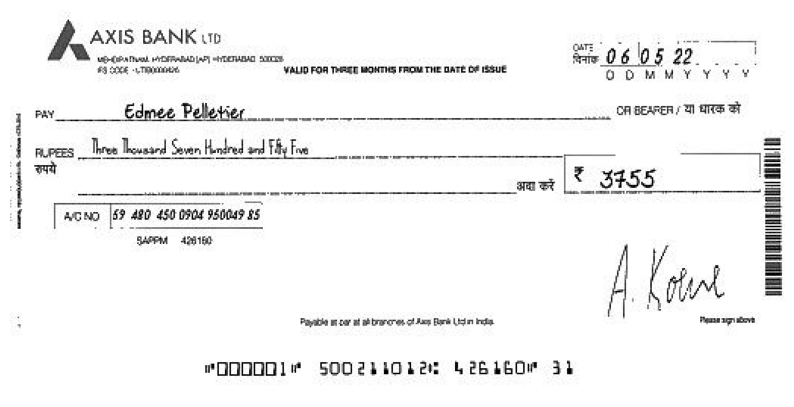

In [7]:
image1 = load_image('1.jpg')

parsed_text1 = parse_text(
    image1, 
    processor, 
    model_parser,
)
print(parsed_text1)

show_image(image1)

{'amt_in_words': 'Three Thousand One Hundred and Sixty Eight', 'amt_in_figures': '3168', 'payee_name': 'Renata Lukic', 'bank_name': 'AXIS BANK', 'cheque_date': '06/05/22'}


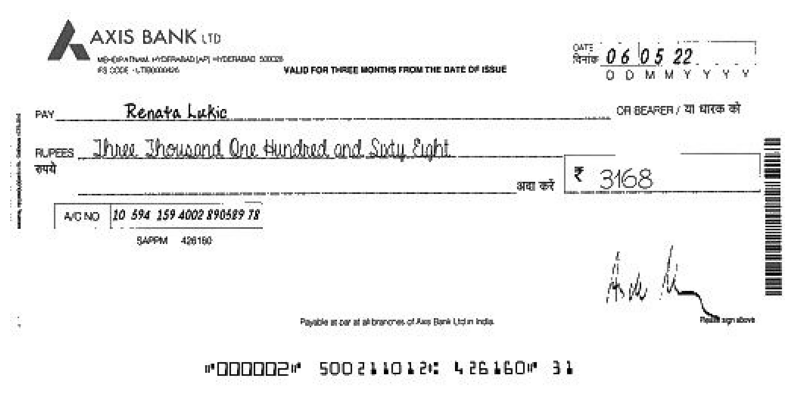

In [8]:
image2 = load_image('2.jpg')

parsed_text2 = parse_text(
    image2, 
    processor, 
    model_parser,
)
print(parsed_text2)

show_image(image2)

{'amt_in_words': 'Three Hundred and Thirty Six', 'amt_in_figures': '3318', 'payee_name': 'Naomi Grant', 'bank_name': 'AXIS BANK', 'cheque_date': '06/05/22'}


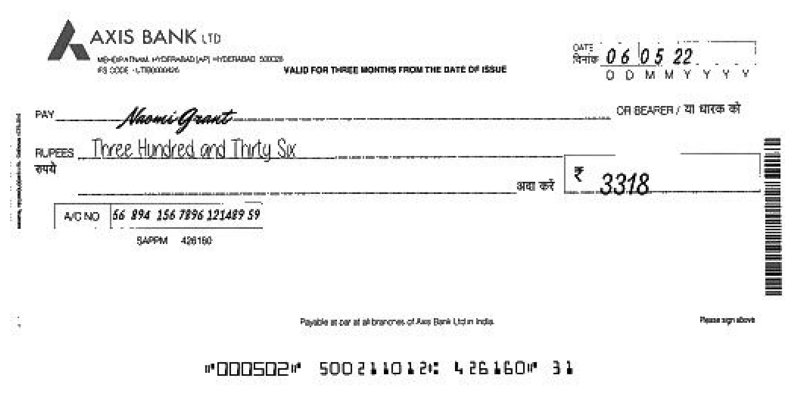

In [9]:
image502 = load_image('502.jpg')

parsed_text502 = parse_text(
    image502, 
    processor, 
    model_parser,
)
print(parsed_text502)

show_image(image502)

{'amt_in_words': 'missing', 'amt_in_figures': '8999', 'payee_name': 'Colette Monjeau', 'bank_name': 'AXIS BANK', 'cheque_date': '06/05/22'}


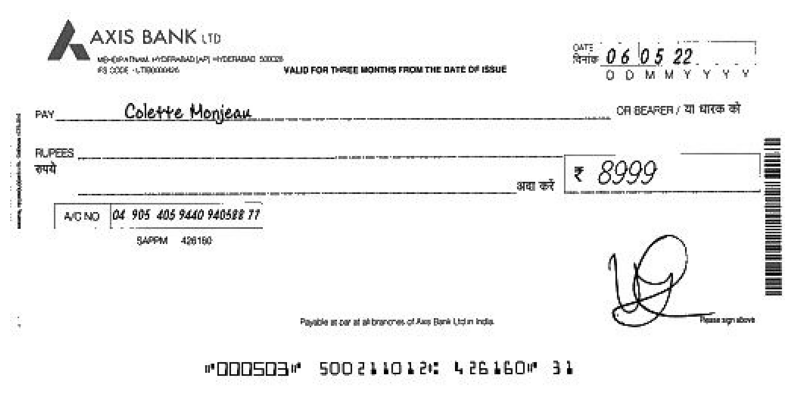

In [10]:
image503 = load_image('503.jpg')

parsed_text503 = parse_text(
    image503, 
    processor, 
    model_parser,
)
print(parsed_text503)

show_image(image503)

## <span style='color:#ff5f27'>👨🏻‍⚖️ Check Evaluation </span>


In [11]:
evaluate_cheque_fraud(
    parsed_text1, 
    model_fraud_detection,
)

('fraud',
 'Spelling is correct: True',
 'Numeric and alphabetic values match: False')

In [12]:
evaluate_cheque_fraud(
    parsed_text2, 
    model_fraud_detection,
)

('valid',
 'Spelling is correct: True',
 'Numeric and alphabetic values match: True')

In [13]:
image3 = load_image('3.jpg')

parsed_text3 = parse_text(
    image3, 
    processor, 
    model_parser,
)

evaluate_cheque_fraud(
    parsed_text3, 
    model_fraud_detection,
)

('valid',
 'Spelling is correct: True',
 'Numeric and alphabetic values match: True')

In [14]:
evaluate_cheque_fraud(
    parsed_text502, 
    model_fraud_detection,
)

('fraud',
 'Spelling is correct: True',
 'Numeric and alphabetic values match: False')

In [15]:
evaluate_cheque_fraud(
    parsed_text503, 
    model_fraud_detection,
)

('fraud',
 'Spelling is correct: False',
 "Numeric and alphabetic values match: (False, 'Amount in words is missing')")

## <span style='color:#ff5f27'>🔗 LLM Chain Loading </span>


In [16]:
llm_chain = get_llm_chain()

🔑 Enter your HuggingFace API key:  ·····································


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-05-13 15:31:08,019 INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

⛳️ Device: cuda:0


## <span style='color:#ff5f27'>🚀 Inference </span>


In [17]:
response = generate_response(
    '2.jpg', 
    processor, 
    model_parser, 
    model_fraud_detection, 
    llm_chain,
    verbose=True,
)
print(response)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


📖 Context:
Amount in words: Three Thousand One Hundred and Sixty Eight
Amount in numbers: 3168
Spelling is correct: True
Numeric and alphabetic values match: True
Verdict: valid
----------

Valid | The cheque is considered valid because the amount in words "Three Thousand One Hundred and Sixty Eight" matches the amount in numbers "3168" and the spelling is correct.


In [18]:
response = generate_response(
    '3.jpg', 
    processor, 
    model_parser, 
    model_fraud_detection, 
    llm_chain,
    verbose=True,
)
print(response)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


📖 Context:
Amount in words: Six Thousand Nine Hundred and Forty Two
Amount in numbers: 6942
Spelling is correct: True
Numeric and alphabetic values match: True
Verdict: valid
----------

Valid | The cheque is considered valid because the amount in words "Six Thousand Nine Hundred and Forty Two" matches the amount in numbers 6942 and the spelling is correct.


In [19]:
response = generate_response(
    '502.jpg', 
    processor, 
    model_parser, 
    model_fraud_detection, 
    llm_chain,
    verbose=True,
)
print(response)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


📖 Context:
Amount in words: Three Hundred and Thirty Six
Amount in numbers: 3318
Spelling is correct: True
Numeric and alphabetic values match: False
Verdict: fraud
----------

Fraud | The cheque is fraudulent due to a mismatch between the numeric and alphabetic values. The amount in words is "Three Hundred and Thirty Six", while the amount in numbers is "3318", which indicates that the cheque has been tampered with, making it invalid.


In [20]:
response = generate_response(
    '503.jpg', 
    processor, 
    model_parser, 
    model_fraud_detection, 
    llm_chain,
    verbose=True,
)
print(response)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


📖 Context:
Amount in words: missing
Amount in numbers: 8999
Spelling is correct: False
Numeric and alphabetic values match: (False, 'Amount in words is missing')
Verdict: fraud
----------

Fraud | The cheque is considered fraudulent because the amount in words is missing, which is a crucial detail that should be included in a valid cheque.


## <span style='color:#ff5f27'>🗄️ Batch Inference </span>


In [21]:
from os import listdir
from os.path import isfile, join

FOLDER_NAME = 'cheques_batch/'

cheque_names = [image for image in listdir(FOLDER_NAME)]
cheque_names

['1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '1001.jpg',
 '1002.jpg',
 '1003.jpg',
 '1004.jpg',
 '1005.jpg',
 '1006.jpg',
 '1007.jpg',
 '1008.jpg',
 '1009.jpg',
 '101.jpg',
 '1010.jpg']

In [22]:
cheque_batch_validation = [
    generate_response(
        cheque_name, 
        processor, 
        model_parser, 
        model_fraud_detection, 
        llm_chain,verbose=False,
        folder_name=FOLDER_NAME,
    ) 
    for cheque_name 
    in cheque_names
]

responses_formatted = [
    format_response(response) 
    for response 
    in cheque_batch_validation
]

cheque_validation_df = pd.DataFrame(
    responses_formatted, 
    columns=['status', 'description'],
)

cheque_validation_df.head()

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
--- Logging error ---
Traceback (most recent call last):
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % s

,status,description
0,Fraud,The cheque is fraudulent due to a mismatch bet...
1,Valid,The cheque is considered valid because the amo...
2,Valid,The cheque is considered valid because the amo...
3,Valid,The cheque is considered valid because the amo...
4,Fraud,The cheque is fraudulent because the amount in...


## <span style="color:#ff5f27;"> 🪄 Feature Group Creation </span>

In [23]:
from hsfs.feature import Feature

features = [
    Feature(name="cheque_id", type="bigint"),
    Feature(name="status", type="string"),
    Feature(name="description", type="string", online_type = "TEXT"),
]

In [24]:
# Get or create the 'cheque_validation' feature group
cheque_validation_fg = fs.get_or_create_feature_group(
    name="cheque_validation_fg",
    version=1,
    description='Cheque Validation and description',
    primary_key=['cheque_id'],
    online_enabled=True,
    features=features,
)

In [26]:
cheque_validation_df_w_index = get_cheque_ids(
    cheque_validation_fg, 
    cheque_validation_df,
)
cheque_validation_df_w_index.head(3)

,status,description,cheque_id
0,Fraud,The cheque is fraudulent due to a mismatch bet...,45
1,Valid,The cheque is considered valid because the amo...,46
2,Valid,The cheque is considered valid because the amo...,47


In [27]:
cheque_validation_fg.insert(
    cheque_validation_df_w_index,
)

Uploading Dataframe: 0.00% |          | Rows 0/15 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: cheque_validation_fg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/11385/jobs/named/cheque_validation_fg_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f9044294d60>, None)

---